### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [4]:
data_dir='../../Data/Weather'
file_index='BBBSBBBB'

### Read the data frame from pickle file

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [6]:
#read data
filename=data_dir+'/US_Weather_BBBSBBBB.csv'
List=load(open(filename,'rb'))
print 'length of List=',len(List)

df=sqlContext.createDataFrame(List)
print df.count()
df.show(5)

length of List= 13047
13047
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[80 4D 00 46 E0 5...|1931.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[00 4F 80 51 00 4...|1932.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[20 D0 00 53 A0 5...|1933.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[30 55 80 C9 A0 D...|1934.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     1|[E0 50 00 CF 00 5...|1935.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [7]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00198301')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00198301'
26 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[80 4D 00 46 E0 5...|1931.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[00 4F 80 51 00 4...|1932.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(26, 365)

### Script for plotting yearly plots

In [8]:
%%writefile lib/YearPlotter.py
from datetime import date
from numpy import shape
from matplotlib.dates import MonthLocator, DateFormatter
class YearPlotter:
    def __init__(self):
        start=365*1+1
        self.dates=[date.fromordinal(i) for i in range(start,start+365)]
        self.monthsFmt = DateFormatter("%b")
        self.months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
    def plot(self,T,fig,ax,title=''):
        if shape(T)[0] != 365:
            raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
        ax.plot(self.dates,T);
        ax.set_title(title)
        ax.xaxis.set_major_locator(self.months)
        ax.xaxis.set_major_formatter(self.monthsFmt)
        # rotate and align the tick labels so they look better
        fig.autofmt_xdate()
        ax.grid()
        

Overwriting lib/YearPlotter.py


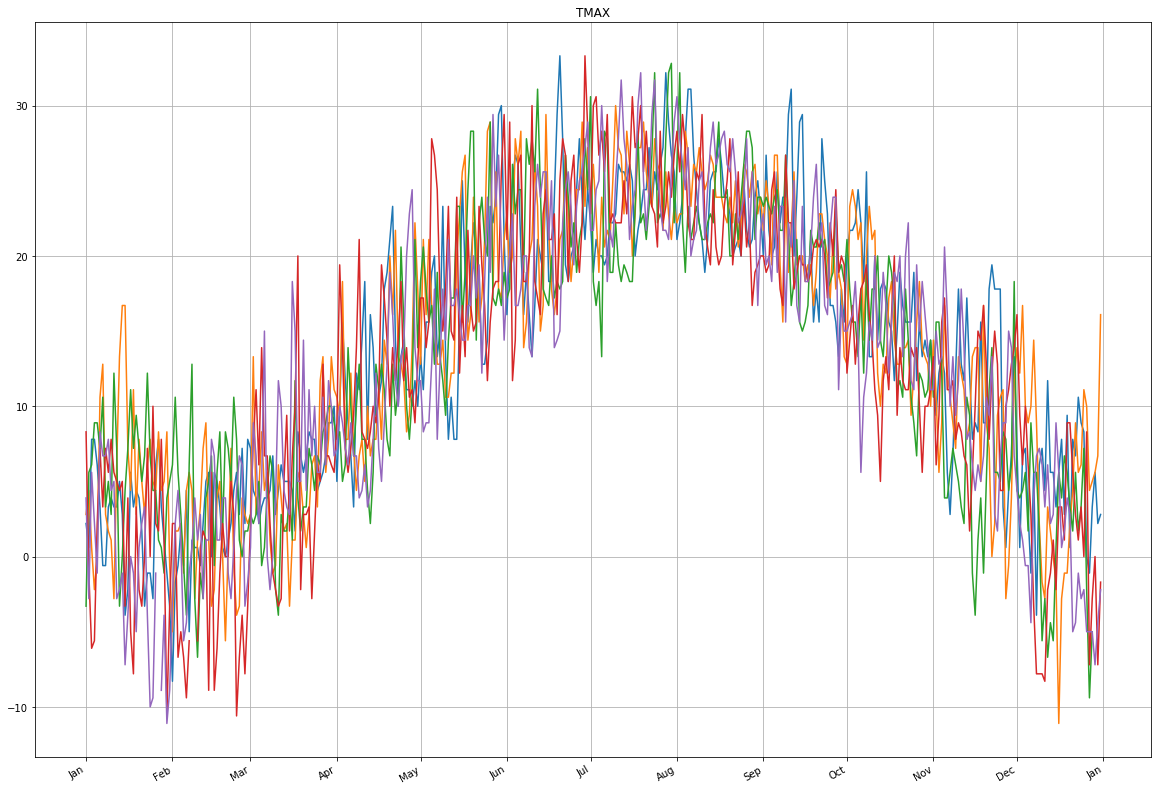

In [9]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(20,15));
YP=YearPlotter()
YP.plot(T[:5,:].transpose(),fig,ax,title='TMAX')
#title('A sample of graphs');

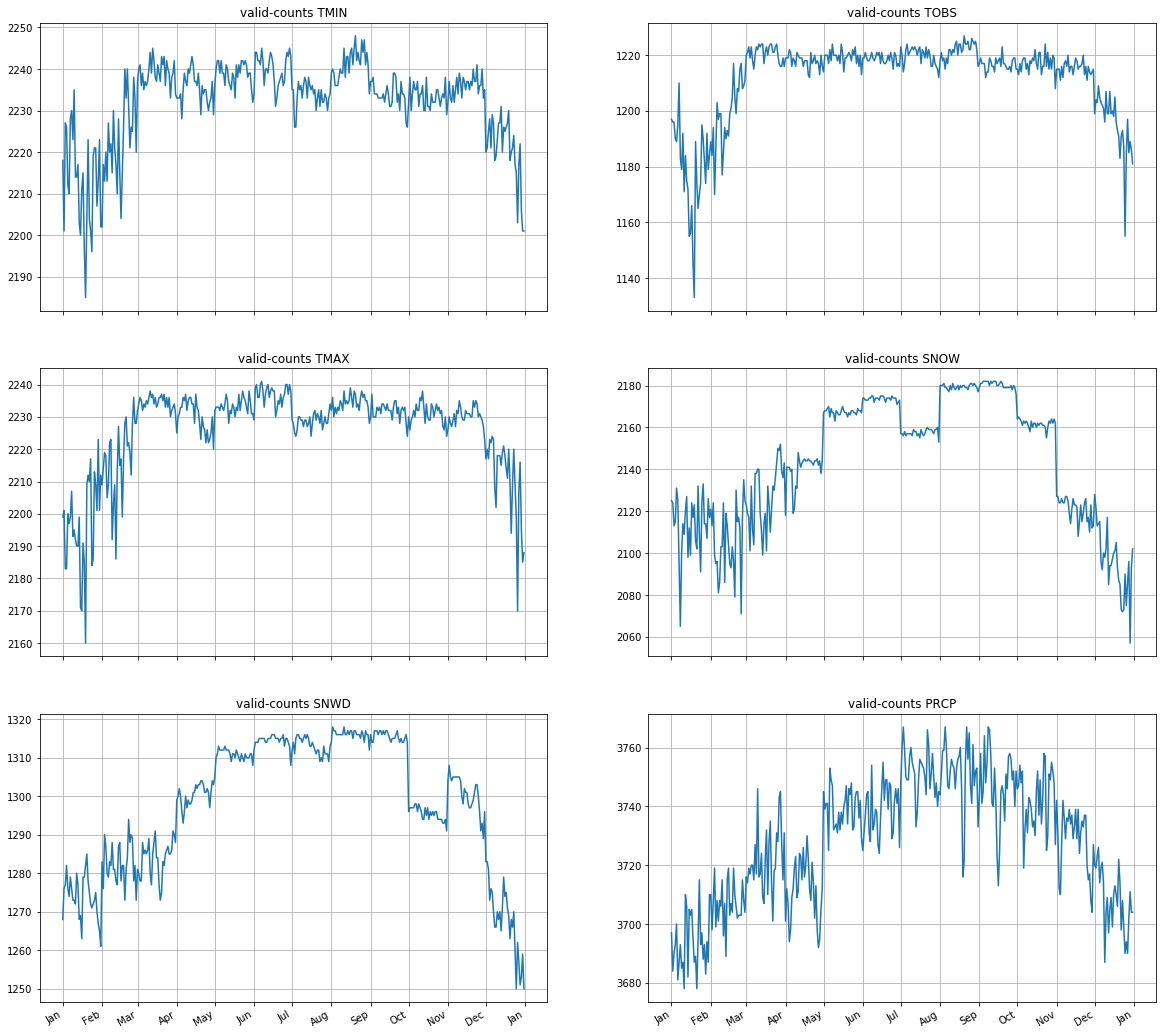

In [10]:
j=0
fig,X=subplots(3,2,figsize=(20,20))
axes=X.reshape(6)
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    axis = axes[j]
    j+=1
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)

### Script for plotting mean of observations

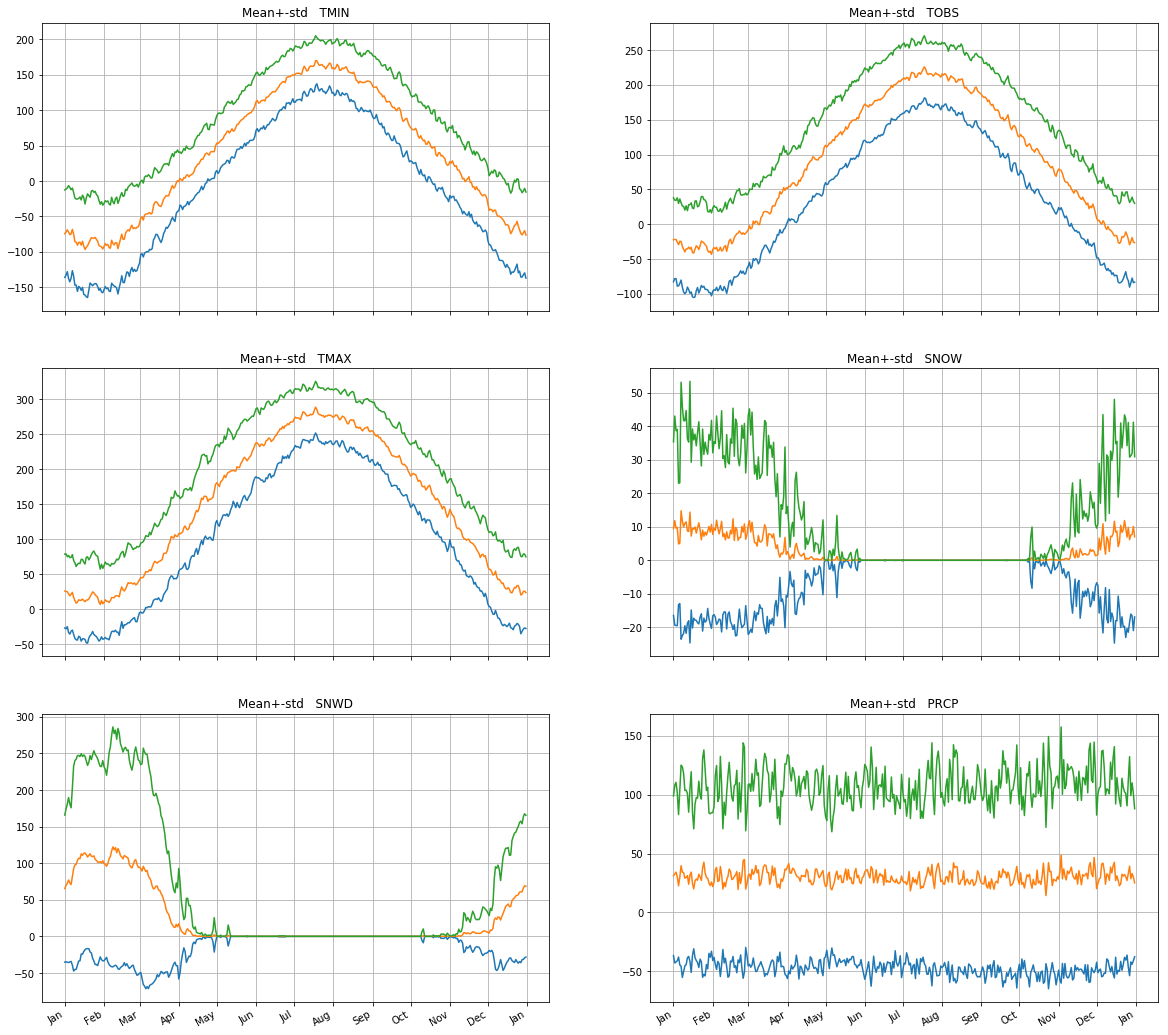

In [13]:
j=0
fig,X=subplots(3,2,figsize=(20,20))
axes=X.reshape(6)
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    axis = axes[j]
    j+=1
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)
  

### Script for plotting top 3 eigenvectors

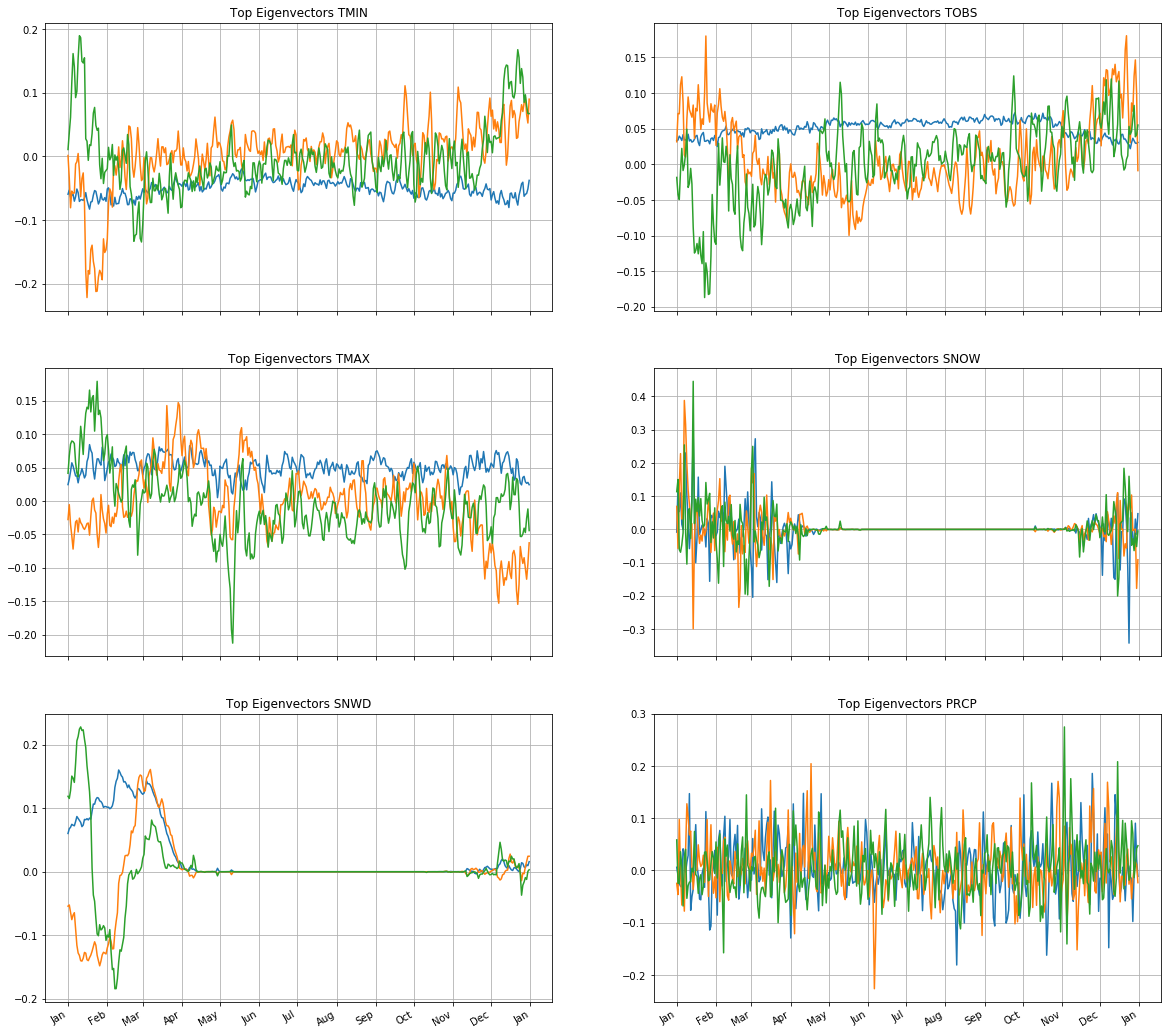

In [14]:
j=0
fig,X=subplots(3,2,figsize=(20,20))
axes=X.reshape(6)
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    axis = axes[j]
    j+=1
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)


### Script for plotting percentage of variance explained

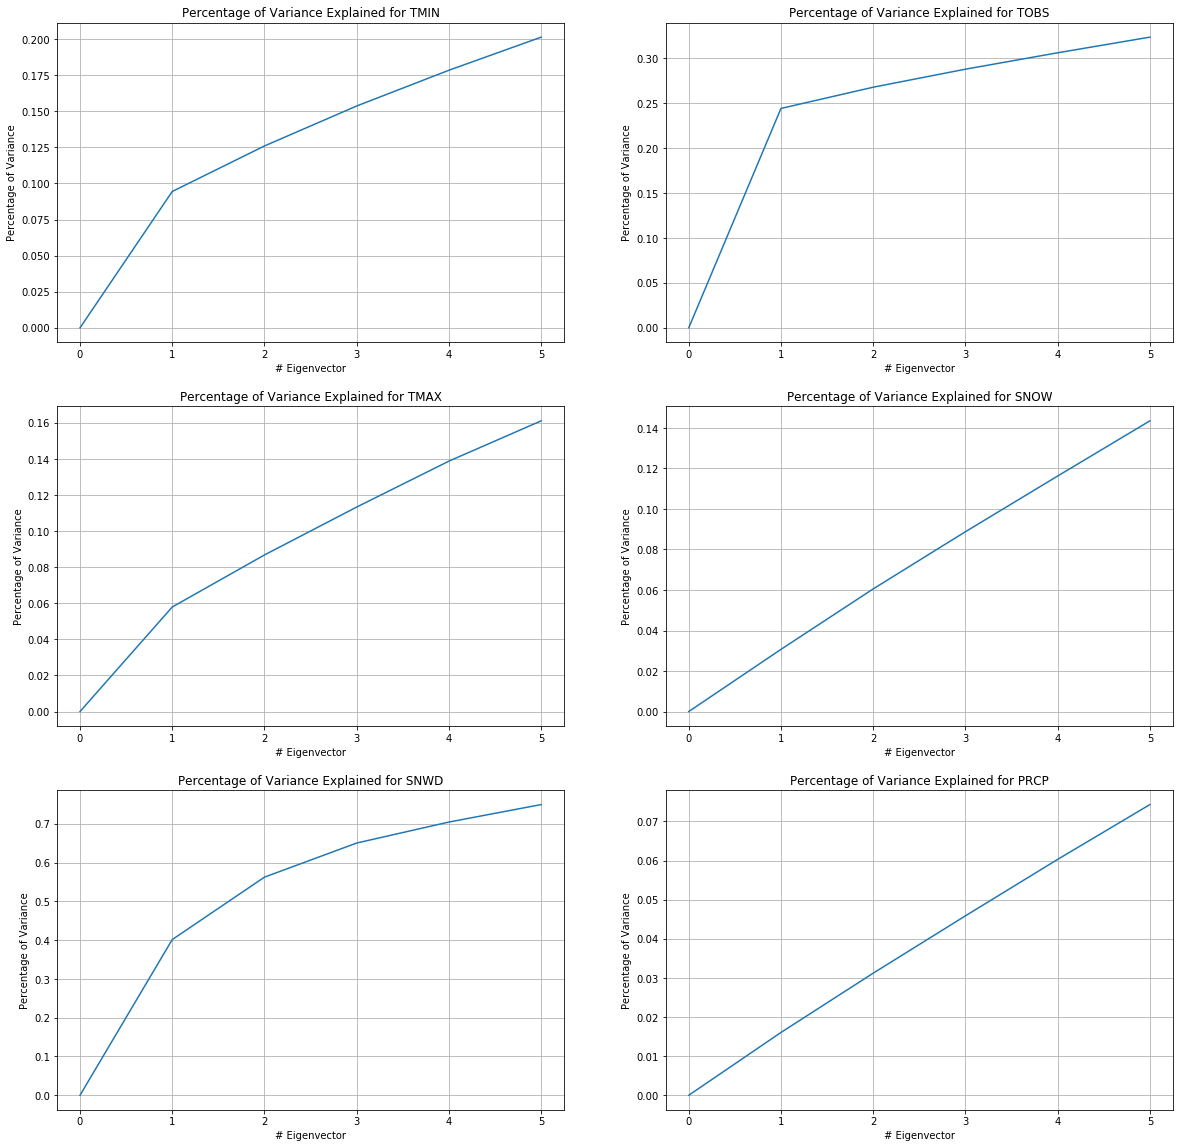

In [15]:
f=plt.figure(figsize=(20,20))
j=1
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    subplot(3,2,j)
    j+=1
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()